In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

import folium
from folium.plugins import MarkerCluster
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

from scipy import stats

In [2]:
# Print current working directory
print(f"Current directory: {os.getcwd()}")

# Change to parent directory
os.chdir('..')

print(f"Current directory: {os.getcwd()}")

Current directory: /Users/apple/Documents/GitHub/data_science_project/notebooks
Current directory: /Users/apple/Documents/GitHub/data_science_project


In [3]:
# Standardize the relevant features
from sklearn.preprocessing import StandardScaler

# Load the data

In [4]:
tj_df=pd.read_csv("clean_data/trader_joes_locations.csv")
tj_df['lat'] = tj_df['lat'].astype(float)
tj_df['lon'] = tj_df['lon'].astype(float)

In [5]:
tj_df.columns

Index(['name', 'zip_code', 'opening_order', 'lat', 'lon', 'status', 'borough'], dtype='object')

In [6]:
final_df=pd.read_csv("clean_data/final.csv")

In [7]:
final_df.head()

,zip_code,total_population,male_population,female_population,age_under_18,age_18_to_44,age_45_plus,race_white,race_native_american,race_asian,...,borough,PO_NAME,area_sqkm,area_sqmi,population_density,Education Index,Median_Household_Income,bus_stop_count,subway_count,total_stores
0,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Manhattan,Central Park,38.300990,14.788089,NaN,NaN,NaN,0.0,0.0,0.0
1,10001,29079.0,14069.0,15010.0,4010.6,15181.4,6331.0,15893.0,32.0,5228.0,...,Manhattan,New York,17.794941,6.870662,1634.116144,105.0,15097.0,63.0,7.0,46.0
2,10002,75517.0,38110.0,37407.0,10757.2,28954.8,18537.0,23597.0,262.0,27700.0,...,Manhattan,New York,26.280129,10.146810,2873.539973,69.8,35771.0,84.0,5.0,129.0
3,10003,53825.0,26407.0,27418.0,9148.8,27316.2,9077.0,36193.0,68.0,9639.0,...,Manhattan,New York,15.538376,5.999398,3464.004157,106.4,25080.0,57.0,7.0,59.0
4,10004,3875.0,2118.0,1757.0,793.8,2117.2,787.0,2460.0,0.0,923.0,...,Manhattan,New York,13.554813,5.233541,285.876307,124.6,1775.0,30.0,3.0,5.0


In [8]:
final_df.columns.to_list()

['zip_code',
 'total_population',
 'male_population',
 'female_population',
 'age_under_18',
 'age_18_to_44',
 'age_45_plus',
 'race_white',
 'race_native_american',
 'race_asian',
 'pop_25_over',
 'pct_bachelors_plus_25_over',
 'count_bachelors_plus_25_over',
 'pop_18_24',
 'pct_bachelor_and_over_18_24',
 'count_bachelors_plus_18_24',
 'shape_area',
 'borough',
 'PO_NAME',
 'area_sqkm',
 'area_sqmi',
 'population_density',
 'Education Index',
 'Median_Household_Income',
 'bus_stop_count',
 'subway_count',
 'total_stores']

In [9]:
tj_df.head()

,name,zip_code,opening_order,lat,lon,status,borough
0,Trader Joe's 72nd & Broadway,10023,542,40.7775,-73.9821,Open,Manhattan
1,Trader Joe's Chelsea,10010,543,40.7424,-73.9936,Open,Manhattan
2,Trader Joe's East Village,10009,546,40.7311,-73.9808,Open,Manhattan
3,Trader Joe's Essex Crossing,10002,538,40.7165,-73.9891,Open,Manhattan
4,Trader Joe's Harlem,10027,576,40.8121,-73.9448,Open,Manhattan


# Merge to the zip-code that contains TJ

## Internal Pattern Analysis
This approach focuses on finding which demographic characteristics are most consistent across existing Trader Joe's locations, suggesting these are critical factors in their site selection.

In [10]:
final_df['female_ratio']=final_df['female_population']  / final_df['total_population']
final_df['male_ratio']=final_df['male_population']/final_df['total_population']

In [11]:
# Merge TJ data with demographic data
tj_demographics = pd.merge(tj_df, final_df, on='zip_code')

# Define variables for analysis based on available columns in final_df
demographic_vars = [
    'total_population', 'age_18_to_44',
    'pct_bachelors_plus_25_over', 'Education Index', 'Median_Household_Income',
    'bus_stop_count', 'subway_count', 'female_population','female_ratio','male_ratio',
    'race_white', 'race_asian', 'age_under_18', 'age_45_plus'
]

In [12]:
def calculate_cv(df, variables):
    """Calculate coefficient of variation for each variable"""
    results = {}
    for var in variables:
        mean_val = df[var].mean()
        if mean_val != 0:  # Avoid division by zero
            std_val = df[var].std()
            cv = std_val / mean_val
            results[var] = cv
    return pd.Series(results).sort_values()  # Sort by CV (ascending)


In [13]:
# Calculate CV for TJ locations
cv_results = calculate_cv(tj_demographics, demographic_vars)
print("\n1. Internal Consistency Analysis (Coefficient of Variation):")
print("Lower values indicate more consistency across TJ locations")
print(cv_results)


1. Internal Consistency Analysis (Coefficient of Variation):
Lower values indicate more consistency across TJ locations
female_ratio                  0.030009
male_ratio                    0.032348
Education Index               0.250333
pct_bachelors_plus_25_over    0.253868
Median_Household_Income       0.334308
age_18_to_44                  0.347536
total_population              0.351427
female_population             0.355550
race_white                    0.409269
age_45_plus                   0.416618
age_under_18                  0.464159
race_asian                    0.586978
bus_stop_count                0.777278
subway_count                  0.779720
dtype: float64


## Cluster Analysis

In [14]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from sklearn.preprocessing import MinMaxScaler

In [15]:

mm_scaler = MinMaxScaler()
X_tj_normalized = mm_scaler.fit_transform(tj_demographics[demographic_vars])


(<Figure size 1000x1000 with 1 Axes>,
 <PolarAxes: title={'center': "Demographic Profiles of Trader Joe's Locations"}>)

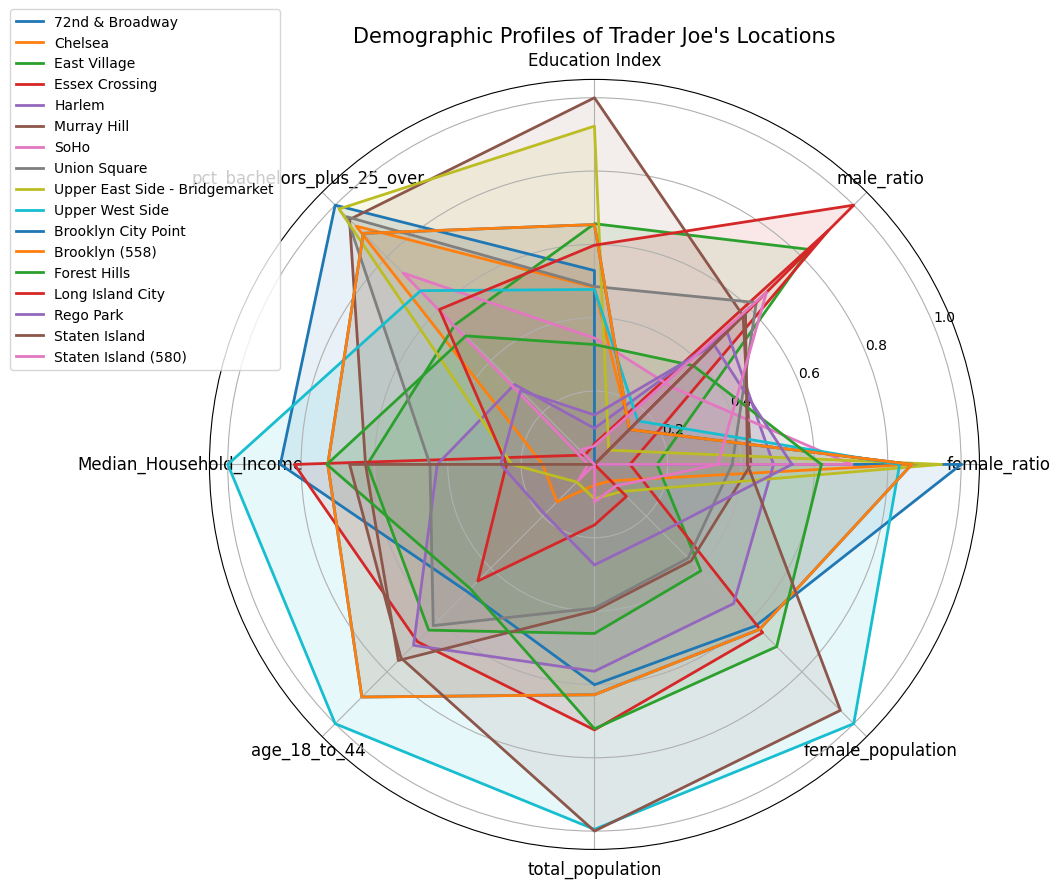

In [16]:

# Function to create radar chart
def radar_chart(df, categories, title):
    # Number of variables
    N = len(categories)
    
    # Create angles for each variable
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], categories, size=12)
    
    # Draw the plots for each store
    for i, store in enumerate(df.index):
        values = df.loc[store].values.tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, label=store)
        ax.fill(angles, values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 1.1))
    plt.title(title, size=15)
    
    return fig, ax

# Create normalized dataframe for radar chart
radar_df = pd.DataFrame(X_tj_normalized, 
                        columns=demographic_vars, 
                        index=[name.replace("Trader Joe's ", "") for name in tj_demographics['name']])

# Select key features (fewer for readability)
key_features = cv_results.index[:8].tolist()

# Plot radar chart
radar_chart(radar_df[key_features], key_features, 'Demographic Profiles of Trader Joe\'s Locations')

Upper West Side (light blue) shows the most distinctive pattern, with notably high values for total population, female population, and age_18_to_44, suggesting a densely populated area with many young adults.

Existing Manhattan locations (the first five entries) show relatively consistent patterns, particularly in education metrics and age distribution, confirming that Trader Joe's targets areas with educated populations and substantial young adult presence.

Outer borough locations like Brooklyn, Staten Island, and Long Island City show different patterns compared to Manhattan locations, particularly in population metrics and education levels.

### We will now plot some by borough to validate our thoughts

In [17]:
def radar_chart_by_borough(final_df, key_metrics):
    # Calculate mean values for each borough for each metric
    borough_means = final_df.groupby('borough')[key_metrics].mean()
    
    # Normalize the data for radar chart
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    borough_means_scaled = pd.DataFrame(
        scaler.fit_transform(borough_means),
        index=borough_means.index,
        columns=borough_means.columns
    )
    
    # Number of variables
    N = len(key_metrics)
    
    # Create angles for each variable
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], key_metrics, size=12)
    
    # Colors for each borough
    colors = {'Manhattan': 'blue', 'Brooklyn': 'green', 'Queens': 'orange', 
              'Bronx': 'red', 'Staten Island': 'purple'}
    
    # Draw the plots for each borough
    for borough in borough_means_scaled.index:
        values = borough_means_scaled.loc[borough].values.tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, label=borough, color=colors[borough])
        ax.fill(angles, values, alpha=0.1, color=colors[borough])
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Demographic Profiles by Borough', size=15)
    
    return fig, ax

In [18]:
def parallel_coordinates_by_borough(final_df, key_metrics):
    # Normalize data for parallel coordinates
    from sklearn.preprocessing import MinMaxScaler
    mm_scaler = MinMaxScaler()
    scaled_data = mm_scaler.fit_transform(final_df[key_metrics])
    
    # Create dataframe for plotting
    parallel_df = pd.DataFrame(scaled_data, columns=key_metrics)
    parallel_df['borough'] = final_df['borough'].values
    
    # Create sample from each borough for cleaner visualization (optional)
    sample_size = min(15, len(parallel_df) // 5)  # At most 15 samples per borough
    sampled_df = parallel_df.groupby('borough').apply(
        lambda x: x.sample(min(sample_size, len(x)), random_state=42)
    ).reset_index(drop=True)
    
    # Plot
    plt.figure(figsize=(14, 8))
    pd.plotting.parallel_coordinates(sampled_df, 'borough', colormap='viridis')
    plt.title('Demographic Profiles by Borough', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    return plt


In [19]:
key_metrics = ['Education Index', 'pct_bachelors_plus_25_over', 
               'Median_Household_Income', 'age_18_to_44', 
               'population_density', 'subway_count']


(<Figure size 1200x1000 with 1 Axes>,
 <PolarAxes: title={'center': 'Demographic Profiles by Borough'}>)

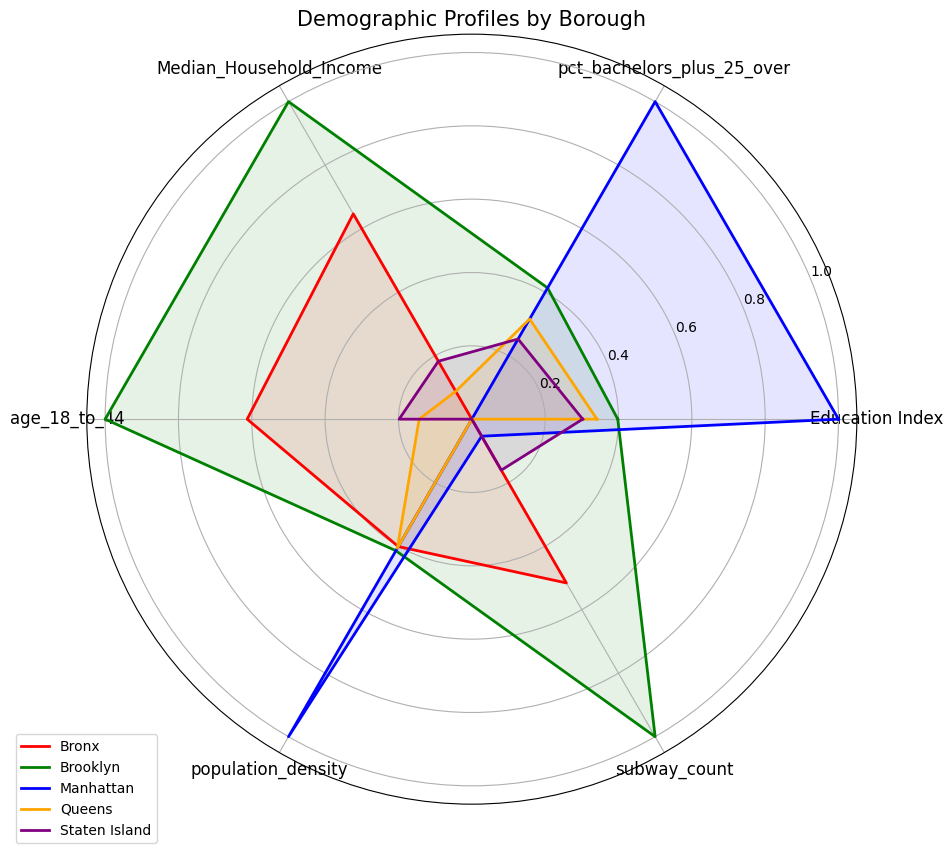

In [20]:
radar_chart_by_borough(final_df, key_metrics)

/var/folders/wg/h6z2ybxs0bnfsz9zc363lx_w0000gn/T/ipykernel_55574/2780668090.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = parallel_df.groupby('borough').apply(


<module 'matplotlib.pyplot' from '/Users/apple/Documents/GitHub/data_science_project/myvnv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

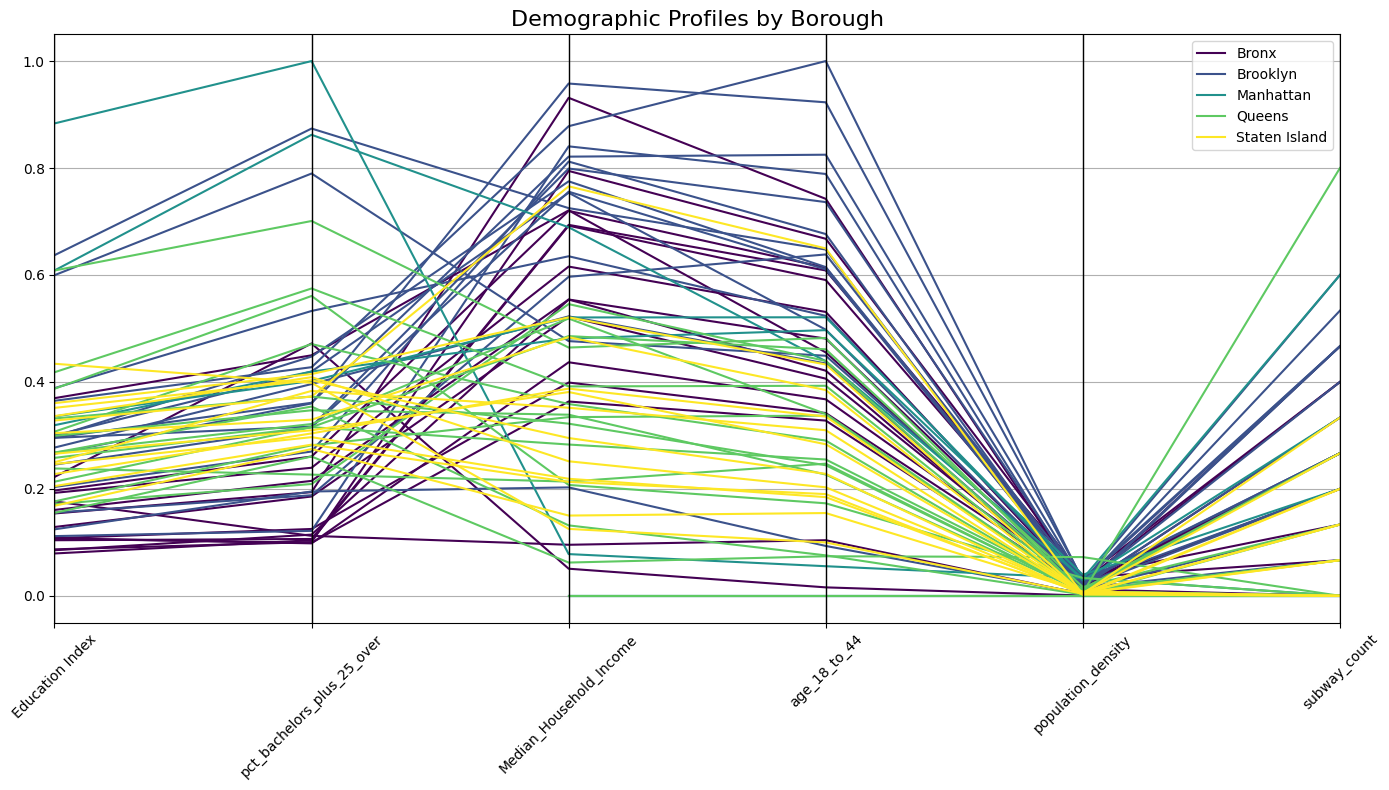

In [21]:
parallel_coordinates_by_borough(final_df, key_metrics)

### TJ based on borough

In [22]:
tj_df.head()

,name,zip_code,opening_order,lat,lon,status,borough
0,Trader Joe's 72nd & Broadway,10023,542,40.7775,-73.9821,Open,Manhattan
1,Trader Joe's Chelsea,10010,543,40.7424,-73.9936,Open,Manhattan
2,Trader Joe's East Village,10009,546,40.7311,-73.9808,Open,Manhattan
3,Trader Joe's Essex Crossing,10002,538,40.7165,-73.9891,Open,Manhattan
4,Trader Joe's Harlem,10027,576,40.8121,-73.9448,Open,Manhattan


In [23]:
tj_demographics.columns

Index(['name', 'zip_code', 'opening_order', 'lat', 'lon', 'status',
       'borough_x', 'total_population', 'male_population', 'female_population',
       'age_under_18', 'age_18_to_44', 'age_45_plus', 'race_white',
       'race_native_american', 'race_asian', 'pop_25_over',
       'pct_bachelors_plus_25_over', 'count_bachelors_plus_25_over',
       'pop_18_24', 'pct_bachelor_and_over_18_24',
       'count_bachelors_plus_18_24', 'shape_area', 'borough_y', 'PO_NAME',
       'area_sqkm', 'area_sqmi', 'population_density', 'Education Index',
       'Median_Household_Income', 'bus_stop_count', 'subway_count',
       'total_stores', 'female_ratio', 'male_ratio'],
      dtype='object')

In [24]:
numeric_cols = tj_demographics.select_dtypes(include=['number']).columns.tolist()



In [25]:
# Filter out any object columns and only use numeric ones for the groupby mean
tj_borough_profiles = tj_demographics.groupby('borough_x')[numeric_cols].mean()


In [26]:
key_metrics = [
    'Education Index',
    'pct_bachelors_plus_25_over',
    'Median_Household_Income',
    'population_density',
    'age_18_to_44',
    'subway_count',
    'total_population',
    'total_stores'
]


In [27]:
# Check which metrics are actually available in our data
available_metrics = [metric for metric in key_metrics if metric in tj_borough_profiles.columns]


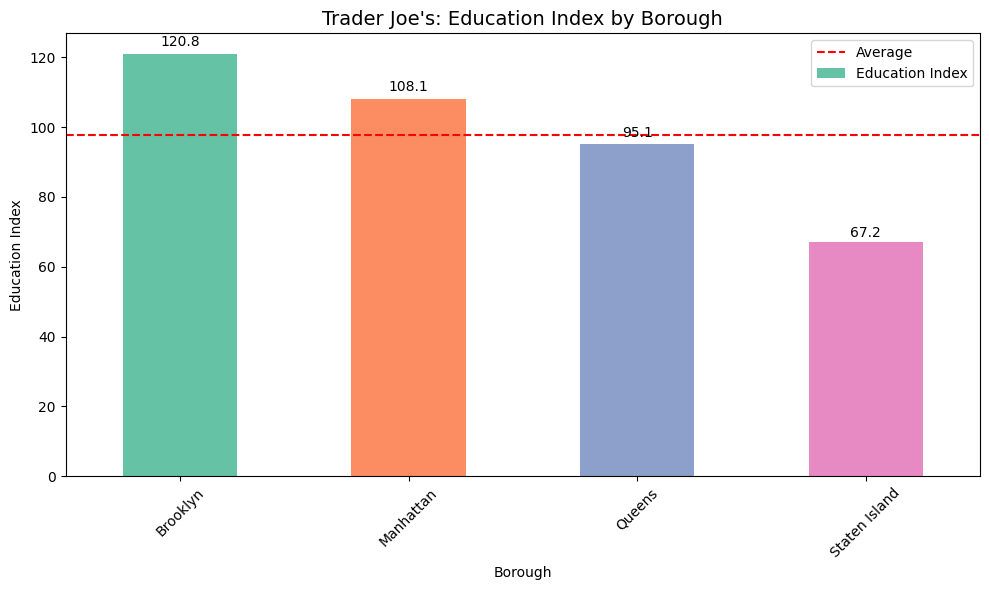

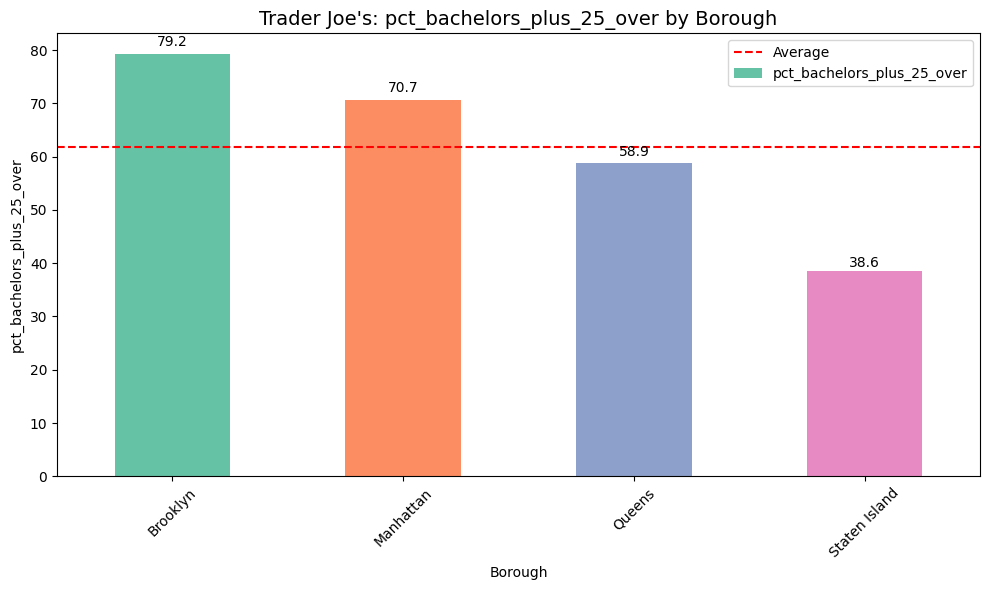

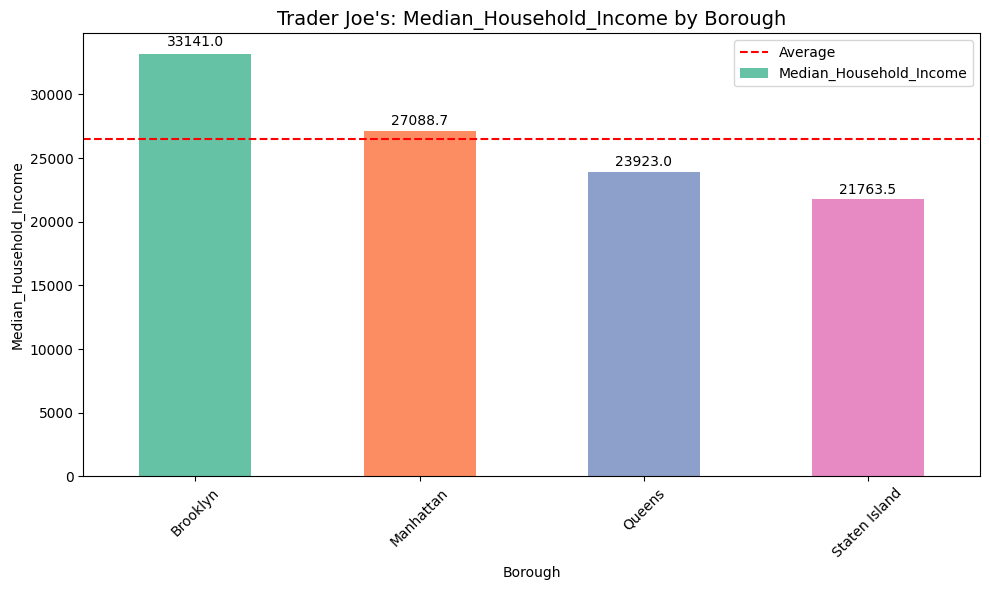

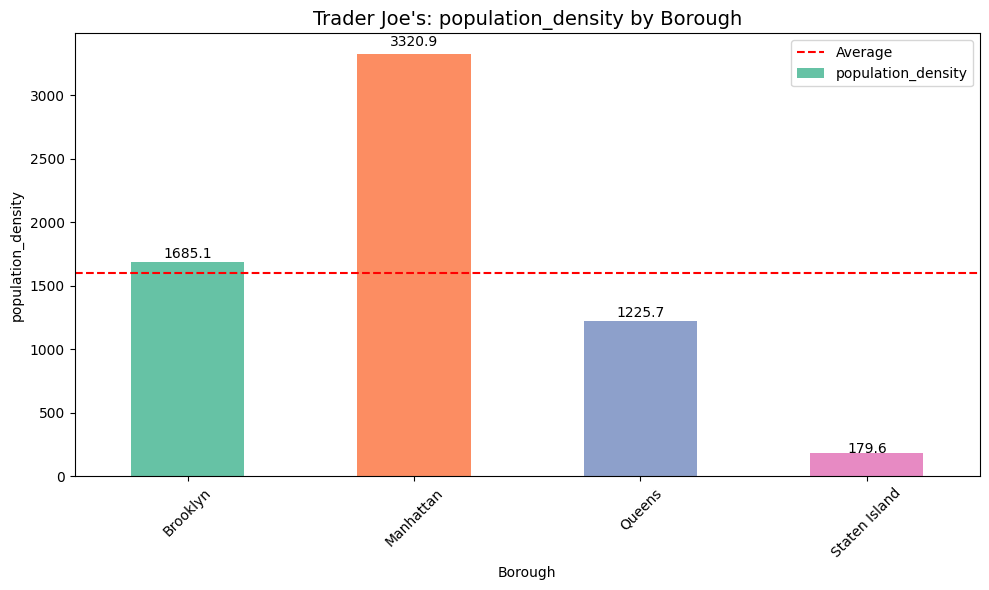

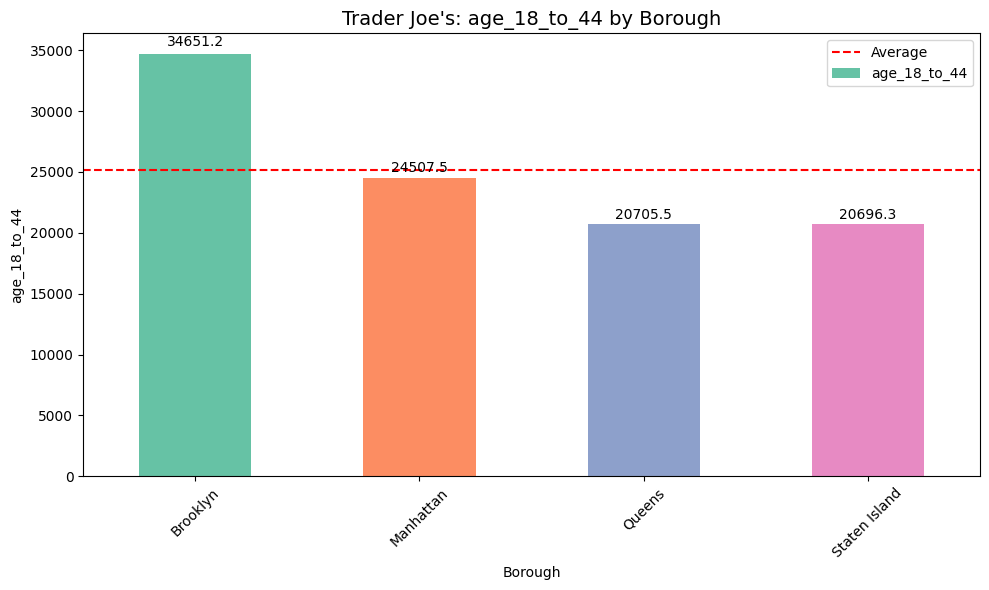

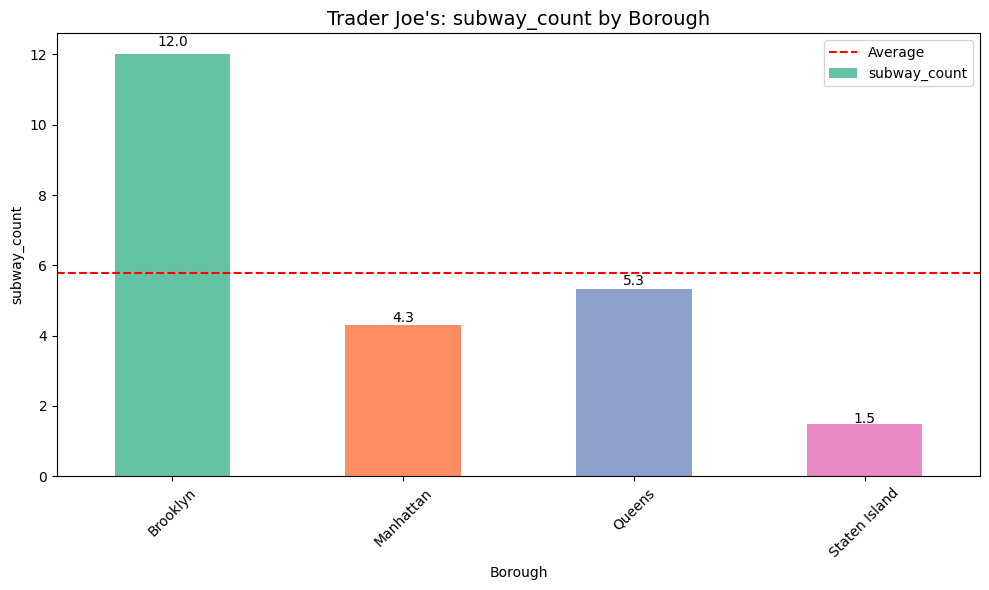

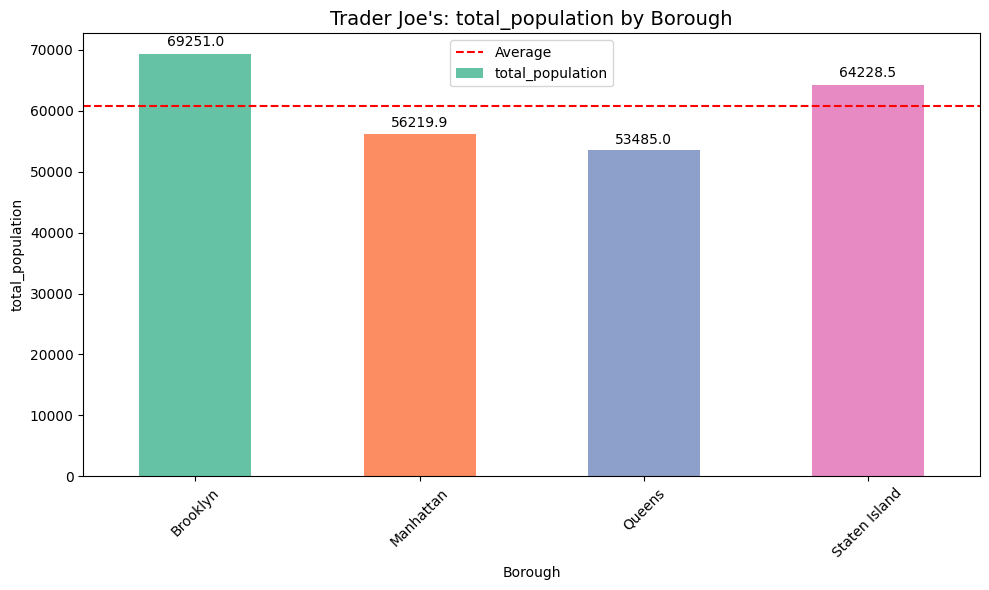

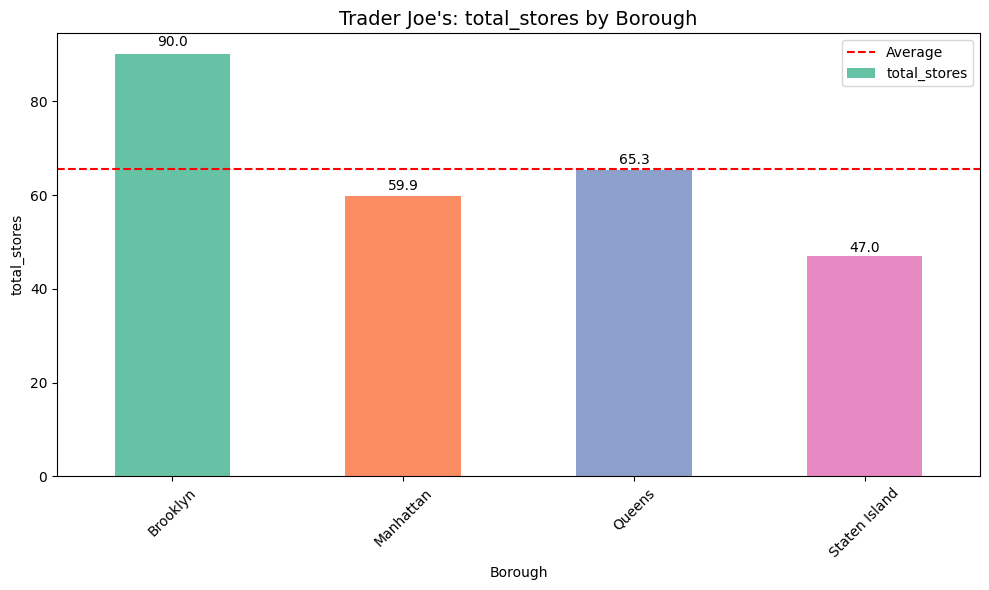

In [28]:
# Create bar charts comparing TJ profiles across boroughs
for metric in available_metrics:
    plt.figure(figsize=(10, 6))
    
    # Create the bar chart
    ax = tj_borough_profiles[metric].plot(kind='bar', color=sns.color_palette("Set2", len(tj_borough_profiles)))
    
    # Add value labels on top of each bar
    for i, v in enumerate(tj_borough_profiles[metric]):
        ax.text(i, v + (v * 0.02), f'{v:.1f}', ha='center')
    
    #show the average line
    avg_value = tj_borough_profiles[metric].mean()
    ax.axhline(y=avg_value, color='red', linestyle='--', label='Average')
    ax.legend()
    # Set the title and labels
    
    
    plt.title(f'Trader Joe\'s: {metric} by Borough', fontsize=14)
    plt.ylabel(metric)
    plt.xlabel('Borough')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

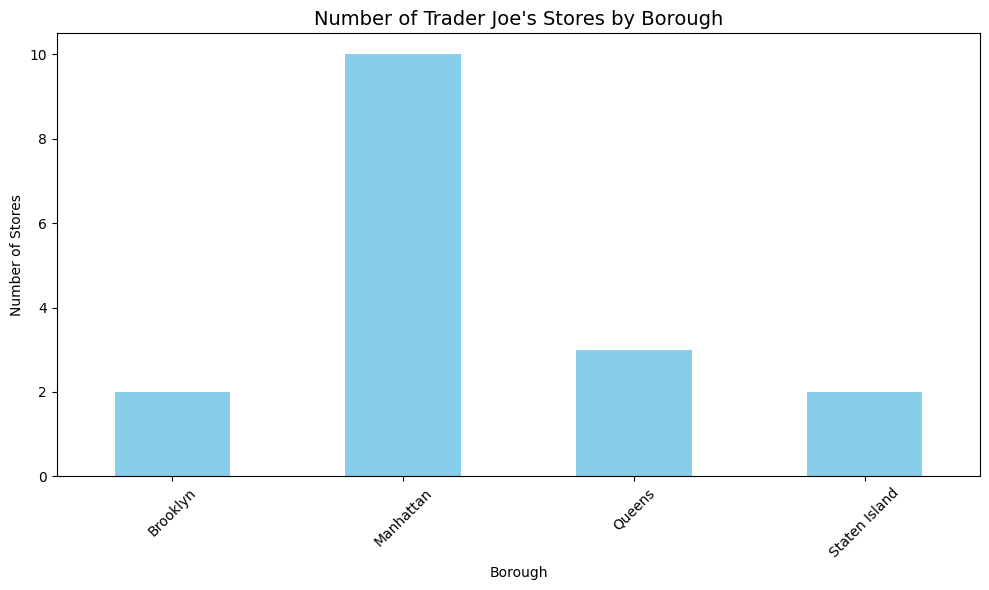

In [29]:
# Count number of stores per borough
store_counts = tj_demographics.groupby('borough_x').size()
plt.figure(figsize=(10, 6))
store_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Trader Joe\'s Stores by Borough', fontsize=14)
plt.ylabel('Number of Stores')
plt.xlabel('Borough')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## PCA Feature

In [30]:
tj_demographics.columns

Index(['name', 'zip_code', 'opening_order', 'lat', 'lon', 'status',
       'borough_x', 'total_population', 'male_population', 'female_population',
       'age_under_18', 'age_18_to_44', 'age_45_plus', 'race_white',
       'race_native_american', 'race_asian', 'pop_25_over',
       'pct_bachelors_plus_25_over', 'count_bachelors_plus_25_over',
       'pop_18_24', 'pct_bachelor_and_over_18_24',
       'count_bachelors_plus_18_24', 'shape_area', 'borough_y', 'PO_NAME',
       'area_sqkm', 'area_sqmi', 'population_density', 'Education Index',
       'Median_Household_Income', 'bus_stop_count', 'subway_count',
       'total_stores', 'female_ratio', 'male_ratio'],
      dtype='object')

In [31]:
scaler = StandardScaler()
X_tj = tj_demographics[demographic_vars].values
X_tj_scaled = scaler.fit_transform(X_tj)

In [32]:
# Perform PCA
pca = PCA()
X_tj_pca = pca.fit_transform(X_tj_scaled)

# Get the loadings
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(len(demographic_vars))],
    index=demographic_vars
)


3. Principal Component Analysis - Feature Loadings:
Shows which variables contribute most to each principal component
                                 PC1       PC2
total_population            0.388725  0.038714
age_18_to_44                0.301331  0.142011
pct_bachelors_plus_25_over -0.134096  0.482736
Education Index            -0.122059  0.396758
Median_Household_Income     0.333684  0.172817
bus_stop_count              0.220948 -0.056004
subway_count               -0.036183  0.223341
female_population           0.386226  0.078906
female_ratio                0.007159  0.455394
male_ratio                 -0.007159 -0.455394
race_white                  0.314983  0.195014
race_asian                  0.223683 -0.203359
age_under_18                0.356268 -0.051777
age_45_plus                 0.371876 -0.044045


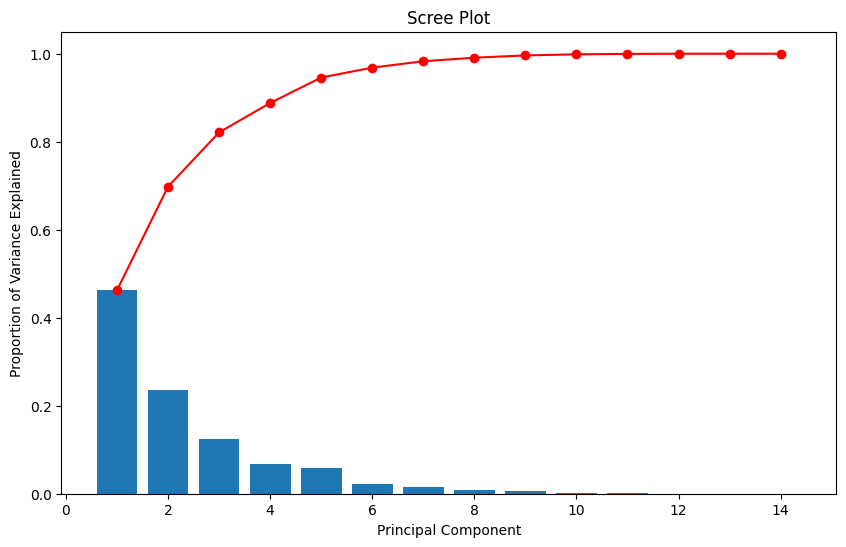

In [33]:
print("\n3. Principal Component Analysis - Feature Loadings:")
print("Shows which variables contribute most to each principal component")
print(loadings[['PC1', 'PC2']])

# Plot variance explained
plt.figure(figsize=(10, 6))
explained_variance = pca.explained_variance_ratio_
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.plot(range(1, len(explained_variance) + 1), 
         np.cumsum(explained_variance), 'ro-')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot')
plt.savefig('tj_pca_scree.png')

* PC1 (46.2% of variance): Primarily represents population characteristics including total population, income, and age distribution.

* PC2 (23.6% of variance): Strongly associated with education measures and gender ratio

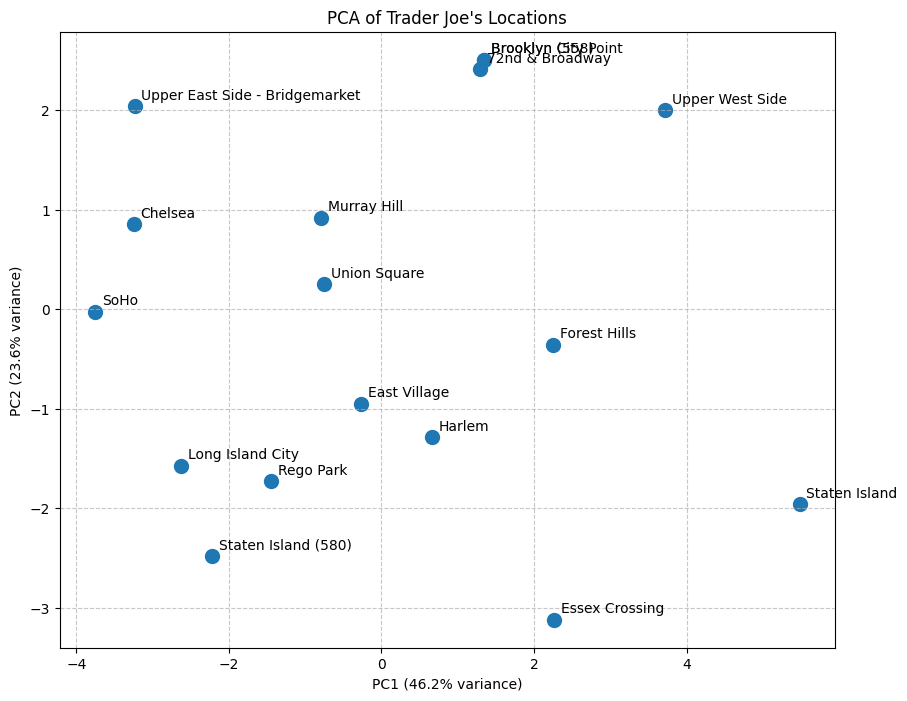

In [34]:
# Plot PCA results
plt.figure(figsize=(10, 8))
plt.scatter(X_tj_pca[:, 0], X_tj_pca[:, 1], s=100)
for i, name in enumerate(tj_demographics['name']):
    plt.annotate(name.replace("Trader Joe's ", ""), 
                 (X_tj_pca[i, 0], X_tj_pca[i, 1]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
plt.title('PCA of Trader Joe\'s Locations')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('tj_pca.png')


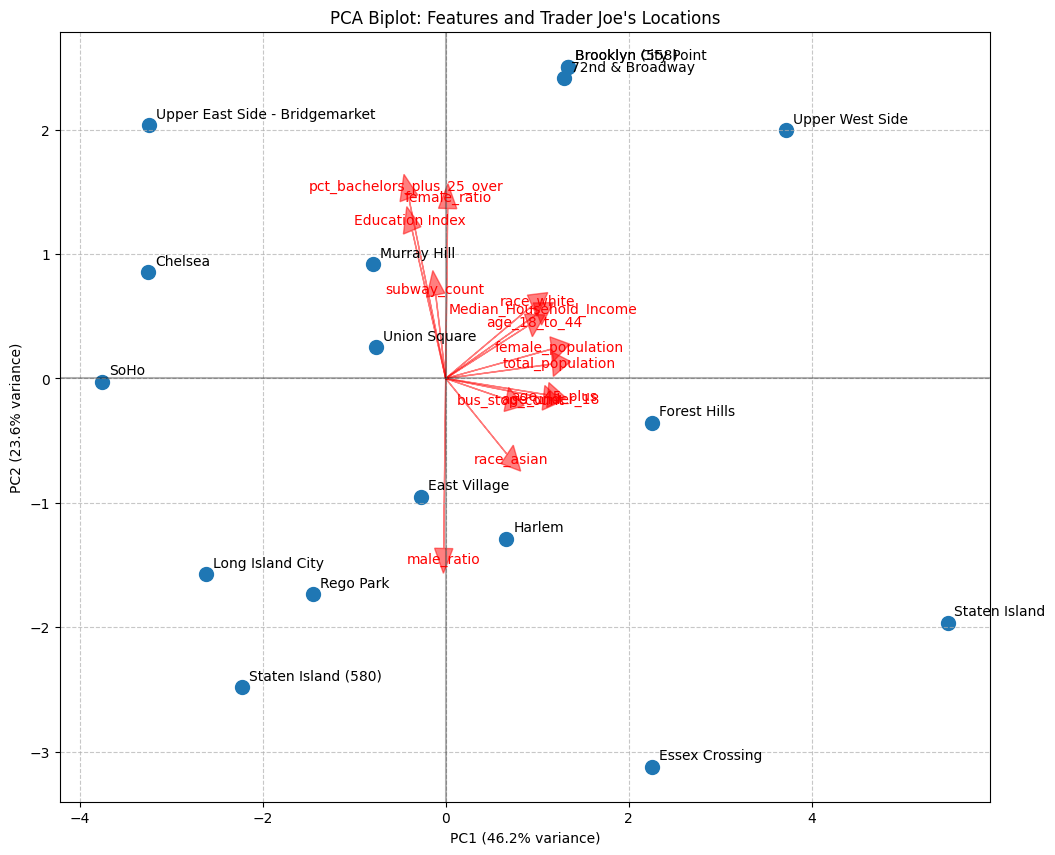

In [35]:
# Plot PCA biplot
plt.figure(figsize=(12, 10))
# Plot PCA scores
plt.scatter(X_tj_pca[:, 0], X_tj_pca[:, 1], s=100)
for i, name in enumerate(tj_demographics['name']):
    plt.annotate(name.replace("Trader Joe's ", ""), 
                 (X_tj_pca[i, 0], X_tj_pca[i, 1]),
                 xytext=(5, 5), textcoords='offset points')

# Plot feature loadings
for i, feature in enumerate(demographic_vars):
    plt.arrow(0, 0, loadings.iloc[i, 0] * 3, loadings.iloc[i, 1] * 3, 
              head_width=0.2, head_length=0.2, fc='red', ec='red', alpha=0.5)
    plt.text(loadings.iloc[i, 0] * 3.2, loadings.iloc[i, 1] * 3.2, feature, 
             color='red', ha='center', va='center')

plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
plt.title('PCA Biplot: Features and Trader Joe\'s Locations')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('tj_pca_biplot.png')

**Borough-Based Clustering**:

* Manhattan Upper-Tier Locations: Upper West Side, Upper East Side, and 72nd & Broadway form a cluster in the upper half of the plot, characterized by high education metrics
* Queens/Brooklyn Middle Tier: Forest Hills, Brooklyn City Point in the right side, balancing population factors with moderate education levels
* Staten Island Outliers: Staten Island locations appear as outliers in the bottom right and bottom left, showing distinct profiles from other boroughs




**TJ's stretegy**
* The wide spread of locations suggests Trader Joe's has evolved from targeting primarily high-education, high-income Manhattan neighborhoods (upper quadrants)
* Their expansion to outer boroughs shows adaptability to different demographic profiles
Essex Crossing (lower right) appears as an outlier, suggesting it may represent a new strategic direction

**Potential New Location Indicators**:

* Areas that would plot in the upper right quadrant (high on both PC1 and PC2) represent the "classic" Trader Joe's demographic
* Areas in the middle right also show promise, with strong population and moderate education metrics
* The bottom right quadrant (high population, lower education) is a newer territory for them

In [36]:
final_df.columns

Index(['zip_code', 'total_population', 'male_population', 'female_population',
       'age_under_18', 'age_18_to_44', 'age_45_plus', 'race_white',
       'race_native_american', 'race_asian', 'pop_25_over',
       'pct_bachelors_plus_25_over', 'count_bachelors_plus_25_over',
       'pop_18_24', 'pct_bachelor_and_over_18_24',
       'count_bachelors_plus_18_24', 'shape_area', 'borough', 'PO_NAME',
       'area_sqkm', 'area_sqmi', 'population_density', 'Education Index',
       'Median_Household_Income', 'bus_stop_count', 'subway_count',
       'total_stores', 'female_ratio', 'male_ratio'],
      dtype='object')